In [5]:
%matplotlib inline
import csv
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import collections
import numpy as np
import lmdb
from time import time
import sqlite3
from twisted.internet import reactor
from twisted.internet.threads import deferToThread
from twisted.internet.defer import DeferredList
from twisted.internet.threads import blockingCallFromThread
from time import sleep
from random import random

In [6]:
def construct_graph(filename):
    G = nx.Graph()
    with open(filename, "r") as csvfile:
        first = True
        for k in csvfile:
            if first:
                first = False
                continue
            a, b = k.split(",")
            G.add_edge(int(a), int(b))
    return G

    
def query_neighbors(G, p1, pn):
    '''
    p1 queries pn about neighbors of the graph G
    '''
    # Honest answer
    return G[pn]

### Build an overlay graph

46


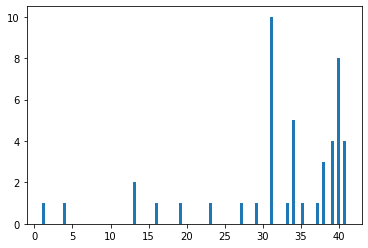

In [7]:
G = construct_graph("peer_connections_new_2.log")
# Discovery community after 210 seconds 
print(G.number_of_nodes())
x = sorted([d for n, d in G.degree()], reverse=True)

fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 100, density=False)
fig.canvas.draw()
plt.show()


In [17]:
# Each peer has a peer view - a ledger of transaction 
# Sync all strategy 
peer_views = {}
# Choose a random target peer
p1 = np.random.choice(G.nodes())
# Choose a neighbor of p1
pn = np.random.choice(G[p1])
# P1 ask about neighbors of pn: HONEST reponse
nodes = query_neighbors(G, p1, pn)
p2 = np.random.choice(nodes)
honest = {p1, p2}
print(len(nodes))
for k in nodes:
    peer_views[k] = dict()
# Calculate alpha - the probablitiy of hiding a transaction 

# Run k rounds of interaction 

detected = dict()


40


In [9]:
def inThread(defs):
    try:
        result = blockingCallFromThread(reactor, DeferredList, defs) 
    except Exception as exc:
        print(exc)
    else:
        #print (result)
        pass
    reactor.callFromThread(reactor.stop)

def txout(val):
    # Peer sleeps for certain time and makes another transaction 
    # Sleep for at most 1 second
    #sleep(random())
    # Peer makes a transaction with target peer 
    # Transaction is put to the local ledger 
    
    # Peer recieves a transactio from a target peer
    # Update local peer view and send and update random neighbours 
    global peer_views
    global detected 
    global honest
    peer_views[val['peer']][val['count']] = val['tx']
    
    
    # Choose randomly some neighbors as witnesses 
    if val['peer'] in honest:
        wit = np.random.choice(list(set(nodes)-{val['peer']}), 5, replace=False)
        for w in wit:    
            if val['count'] in peer_views[w].keys():
                # check if the transaction is the same - double spending/inconsistency
                if peer_views[w][val['count']] != val['tx']:
                    detected[str(val['tx'])] = [val['tx'], peer_views[w][val['count']]]
            else:
                peer_views[w][val['count']] = val['tx']

    

### Sunny day: Honest target peer, honest neighbors, no sync, send to 5

In [6]:

K = 10
t1 = time()
defs = []
counter = 1
total_balance = 100
M = 2
for i in nodes:
    val = np.random.choice([1, -1]) *random()*10
    total_balance += val
    defs.append(deferToThread(txout, {'peer': i, 'count': counter, 'tx':[val, i, total_balance]}))
    counter += 1
    
reactor.callInThread(inThread, defs)
reactor.run()


        


print(time()-t1)

0.01207280158996582


In [7]:
peer_views

{102: {1: [8.51876024870181, 102, 108.51876024870181],
  18: [-0.23994369554897865, 50, 134.37164807778055],
  25: [3.7789470762083797, 108, 142.1354945922027],
  26: [6.667655732831051, 34, 148.80315032503376],
  30: [-2.9414966542931644, 79, 148.99207536303194],
  31: [3.782676466027829, 21, 152.77475182905977],
  41: [5.3698018253344335, 174, 144.8361747731954]},
 176: {2: [-0.6147801084480831, 176, 107.90398014025372],
  3: [-5.793738647002264, 93, 102.11024149325146],
  7: [-0.7262928882071873, 17, 102.04138825784338],
  28: [9.26598510621828, 75, 151.34670015813865]},
 93: {3: [-5.793738647002264, 93, 102.11024149325146],
  5: [-2.094320710885609, 130, 96.19104681115753],
  11: [2.2991535398799634, 169, 97.37685790228811],
  16: [8.060863344667501, 183, 127.58685208215316],
  25: [3.7789470762083797, 108, 142.1354945922027],
  38: [-9.184439688374528, 126, 133.56789045640846],
  40: [6.967601252517807, 92, 139.46637294786098]},
 137: {4: [-3.8248739712083237, 137, 98.285367522043

### Cloudy day: Malicious target peer, honest neighbors, no sync send to 5

In [10]:

K = 10
t1 = time()
defs = []
counter = 1
total_balance = 100
M = 2
for i in nodes.keys():
    val = np.random.choice([1, -1]) *random()*10
    total_balance += val
    defs.append(deferToThread(txout, {'peer': i, 'count': counter, 'tx':[val, i, total_balance]}))
    # pick other node 
    total_balance -= val
    val = np.random.choice([1, -1]) *random()*10
    total_balance += val
    new_peer = np.random.choice(nodes)
    defs.append(deferToThread(txout, {'peer': new_peer, 'count': counter, 'tx':[val, new_peer, total_balance]}))
    counter += 1
    
reactor.callInThread(inThread, defs)
reactor.run()


print(time()-t1)

0.019411563873291016


In [11]:
len(nodes)

33

In [12]:
len(detected)

27

In [13]:
peer_views

{34: {1: [4.658257010194761, 34, 104.65825701019476],
  4: [-6.615341182967203, 21, 102.16490744138186],
  7: [-7.636244093368598, 181, 85.60651521064067],
  8: [-6.437743397749829, 112, 79.16877181289084],
  11: [2.088766357001579, 17, 86.04965500354265],
  14: [7.880954979209034, 21, 88.40378888216014],
  22: [-0.8597338156652401, 130, 99.40093464828676],
  26: [-9.166744302360716, 34, 68.08096606024355],
  27: [-8.575543291956901, 119, 59.50542276828665],
  31: [-6.994961256288892, 93, 47.624736103319094],
  32: [-2.422544058820143, 126, 62.01785612746564]},
 178: {2: [1.7663290619586247, 178, 106.559285449473],
  6: [-5.056532603437269, 61, 91.98013432542555],
  13: [3.3296962470328784, 124, 85.60430093463387],
  18: [0.8523579895798794, 56, 97.0718567201581],
  22: [-3.824758611537841, 178, 96.43590985241416],
  24: [-8.43746957840595, 112, 80.07864752266418],
  25: [-2.8309371600599373, 1, 77.24771036260425],
  29: [-0.8462109801530415, 50, 54.95978411352088]},
 102: {1: [4.65825

### Rainy day: Malicious target peer, malicious neighbors except 2, no sync send to 5